In [1]:
import torch
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import math

### Data - Sequence Classification

We train a classifier that should detect whether a given sequence is a concatenation of two identical halves.

In [2]:
# digits as characters
def generate(nsamples, nelms):
    x = torch.randint(0,10,size=(nsamples,2*nelms))
    y = torch.randint(0,2,size=(nsamples,))
    x[y==1,nelms:]=x[y==1,0:nelms]
    return x,y

In [3]:
x,y = generate(10,5)
print(y)
print(x)

tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])
tensor([[4, 7, 2, 7, 9, 4, 7, 2, 7, 9],
        [4, 2, 8, 9, 1, 6, 9, 6, 7, 8],
        [0, 3, 1, 3, 3, 0, 3, 1, 3, 3],
        [5, 0, 9, 1, 0, 5, 0, 9, 1, 0],
        [4, 2, 3, 7, 4, 4, 2, 3, 7, 4],
        [0, 0, 2, 1, 5, 0, 0, 2, 1, 5],
        [3, 3, 3, 7, 1, 3, 3, 3, 7, 1],
        [4, 6, 7, 0, 2, 8, 2, 5, 2, 0],
        [8, 4, 2, 9, 1, 9, 3, 1, 8, 0],
        [9, 9, 1, 5, 4, 9, 9, 1, 5, 4]])


In [4]:
class ExampleSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, nsamples, nelms, num_classes=10):
        self.nsamples = nsamples
        self.nelms = nelms
        x, self.y = generate(nsamples, nelms)
        self.X = torch.nn.functional.one_hot(x, num_classes=num_classes).float()

    def __len__(self):
        return self.nsamples

    def __getitem__(self, idx):
        y = self.y[idx]
        x = self.X[idx]
        return x, y

In [5]:
data = ExampleSequenceDataset(1000,8)
loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
X,Y = next(iter(loader))
X[0]

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

### Simple RNN Model (Elman Network)

In [6]:
class RecNet(torch.nn.Module):
    def __init__(self, ninput, nhidden, noutput):
        super().__init__()
        self.linear_x2h = torch.nn.Linear(ninput, nhidden)
        self.linear_h2h = torch.nn.Linear(nhidden, nhidden, bias = False)
        self.linear_h2y = torch.nn.Linear(nhidden, noutput)

    def forward(self, input):
        nsamples, nhidden = input.size(0), self.linear_h2y.weight.size(1) 
        h = torch.zeros(nsamples, nhidden)
        for t in range(input.size(1)):
            h = torch.nn.functional.relu(self.linear_x2h(input[:, t]) + self.linear_h2h(h))
        return self.linear_h2y(h)

In [16]:
def run_experiment(seqlen, nepochs, batchsize, model, lr, clipvalue=-1.0):
    training_data = ExampleSequenceDataset(50000,seqlen)
    test_data = ExampleSequenceDataset(10000,seqlen)
    train_loader = DataLoader(training_data, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

    train_size = len(train_loader.dataset)
    train_batches = len(train_loader)
    test_size = len(test_loader.dataset)
    test_batches = len(test_loader)

    cross_entropy = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    cost_train = []
    cost_test = []
    acc_train = []
    acc_test = []

    for epoch in range(nepochs):
        train_loss = 0.0
        train_acc = 0.0
        for (X,y) in train_loader:
            pred = model(X)
            loss = cross_entropy(pred, y)
            train_loss += loss.item()
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        
            optimizer.zero_grad()
            loss.backward()
            if clipvalue > 0.0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clipvalue)
            optimizer.step()
    
        train_loss /= train_batches
        train_acc /= train_size
        cost_train.append(train_loss)
        acc_train.append(train_acc)
    
        test_loss = 0.0
        test_acc = 0.0
        for (X,y) in test_loader:
            pred = model(X)
            loss = cross_entropy(pred, y)
            test_loss += loss.item()
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        
        test_loss /= test_batches
        test_acc /= test_size
        cost_test.append(test_loss)
        acc_test.append(test_acc)
        
        print(epoch, train_loss, train_acc, test_loss, test_acc)
    return cost_train, acc_train, cost_test, acc_test

In [ ]:
batchsize = 32
nepochs = 20
seqlen = 15
lr = 0.001
clipvalue = -1.0
model = RecNet(ninput = 10, nhidden = 20, noutput = 2)
cost_train, acc_train, cost_test, acc_test = run_experiment(seqlen, nepochs, batchsize, model, lr, clipvalue)

In [81]:
#help(torch.nn.RNN)

In [76]:
class RecNet(torch.nn.Module):
    def __init__(self, ninput, nhidden, noutput):
        super().__init__()
        self.rnn = torch.nn.RNN(ninput, nhidden, batch_first=True)
        self.linear_h2y = torch.nn.Linear(nhidden, noutput)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.linear_h2y(h[0])
    
ninput = 10
nhidden = 50
noutput = 2
model = RecNet(ninput, nhidden, noutput)

batchsize = 32
seqlen = 8
x = torch.randn(batchsize, seqlen, ninput)

pred_score = model(x)
print(pred_score.shape)

torch.Size([32, 2])


In [77]:
class RecNet1(torch.nn.Module):
    def __init__(self, ninput, nhidden, noutput):
        super().__init__()
        self.nhidden = nhidden
        self.rnn = torch.nn.RNN(ninput, nhidden, batch_first=True)
        self.linear_h2y = torch.nn.Linear(nhidden, noutput)

    def forward(self, x):
        nbatch, steps = x.shape[0], x.shape[1]
        ht = torch.zeros(1, nbatch, self.nhidden)
        for t in range(steps):
            xt = x[:, t, :].unsqueeze(1)
            _, ht = self.rnn(xt, ht)
        return self.linear_h2y(ht[0])
    
ninput = 10
nhidden = 50
noutput = 2
model = RecNet1(ninput, nhidden, noutput)

batchsize = 32
seqlen = 8

pred_score1 = model(x)
print(pred_score.shape)
print((pred_score-pred_score1).abs().max())

torch.Size([32, 2])
tensor(0.6446, grad_fn=<MaxBackward1>)


In [102]:
batchsize = 32
nepochs = 30
seqlen = 20
lr = 0.001
clipvalue = -1.0
tries = 3
cost_train, acc_train, cost_test, acc_test = tries*[1], tries*[1], tries*[1], tries*[1]
for i in range(tries):
    model = RecNet(ninput = 10, nhidden = 20, noutput = 2)
    cost_train[i], acc_train[i], cost_test[i], acc_test[i] = run_experiment(seqlen, nepochs, batchsize, model, lr, clipvalue)

0 0.6938797155405876 0.49916 0.6949465040581676 0.4968
1 0.6935680030403577 0.49842 0.6933461172512164 0.4959
2 0.6933697823218177 0.50248 0.6934871702148511 0.5036
3 0.6932943920561387 0.50218 0.6935529545092354 0.4965
4 0.6932760253214942 0.50324 0.6939535738941961 0.4972
5 0.6932176079646335 0.50316 0.6931774675274809 0.5009
6 0.6932530224666485 0.50422 0.6934208738537261 0.5008
7 0.6931877703675839 0.50448 0.6933665266052221 0.5006
8 0.6931078975122859 0.5052 0.6934865871176552 0.4999
9 0.6933585479331185 0.50266 0.6937493049679473 0.5008
10 0.48165667159047865 0.73218 0.2864915002792026 0.8904
11 0.26174121391759875 0.8998 0.29733093904134944 0.8806
12 0.20990121878221182 0.92522 0.1791488016113496 0.9355
13 0.18883811126290914 0.9332 0.1846553127938947 0.9434
14 0.1647874724229539 0.9437 0.14726213863887155 0.9492
15 0.15614276463064583 0.94764 0.1830389042393849 0.9365
16 0.14884953149811853 0.94966 0.11878973731812768 0.9608
17 0.13736562195316826 0.95472 0.12333928098003515 0.

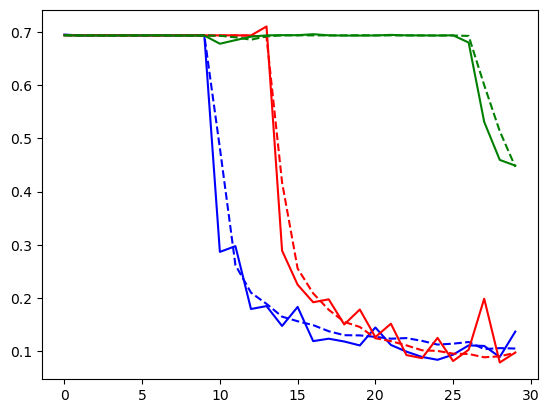

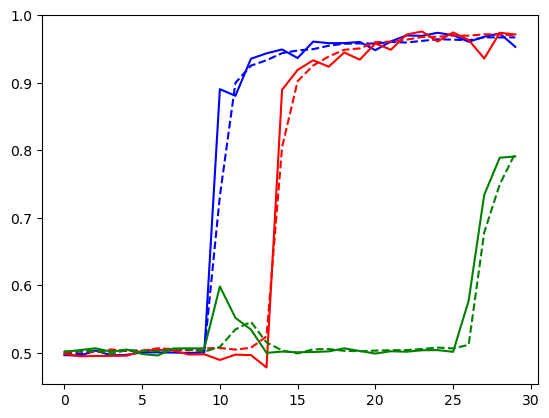

In [103]:
plt.figure(1)
colors = ['b--','b-','r--','r-','g--','g-']
for i in range(tries):
    plt.plot(range(nepochs), cost_train[i], colors[2*i])
    plt.plot(range(nepochs), cost_test[i], colors[2*i+1])

plt.figure(2)
for i in range(tries):
    plt.plot(range(nepochs), acc_train[i], colors[2*i])
    plt.plot(range(nepochs), acc_test[i], colors[2*i+1])

### LSTM

In [114]:
class LSTMNet(torch.nn.Module):
    def __init__(self, ninput, nhidden, noutput):
        super().__init__()
        self.rnn = torch.nn.LSTM(ninput, nhidden, batch_first=True)
        self.linear_h2y = torch.nn.Linear(nhidden, noutput)

    def forward(self, x):
        _, (h, _) = self.rnn(x)
        return self.linear_h2y(h[0])


In [115]:
#help(torch.nn.LSTM)

In [130]:
batchsize = 32
nepochs = 25
seqlen = 5
lr = 0.001
clipvalue = -1.0
tries = 3
cost_train, acc_train, cost_test, acc_test = tries*[1], tries*[1], tries*[1], tries*[1]
for i in range(tries):
    model = LSTMNet(ninput = 10, nhidden = 50, noutput = 2)
    cost_train[i], acc_train[i], cost_test[i], acc_test[i] = run_experiment(seqlen, nepochs, batchsize, model, lr, clipvalue)

0 0.6577963684128403 0.55474 0.4105938603988471 0.812
1 0.1799562453999591 0.93858 0.10409056229856067 0.9688
2 0.08240351802594983 0.97558 0.08737823185168754 0.9733
3 0.059102672151625346 0.98308 0.059447399220063375 0.9817
4 0.04340192009312037 0.98802 0.04331652165952915 0.9863
5 0.03495037398775962 0.9902 0.04064242833758148 0.9877
6 0.028189230213324305 0.99194 0.046188652191084985 0.9868
7 0.025508782632077818 0.9927 0.04561879693235928 0.9857
8 0.020894913638850182 0.99422 0.052269437839797796 0.9835
9 0.01917499874900819 0.99482 0.03430210558300356 0.9893
10 0.017045413162665037 0.99512 0.025677853203940237 0.9928
11 0.014505666058178874 0.99618 0.027268242858612117 0.9929
12 0.01434014321948233 0.99584 0.023119727599180896 0.9931
13 0.011786522356444635 0.99656 0.02076916062165596 0.9946
14 0.011022879288244004 0.9965 0.023418652969367872 0.9943
15 0.00924036389568466 0.99742 0.02436947925298954 0.9943
16 0.008837567007642311 0.99766 0.019518641904618526 0.995
17 0.0077880636

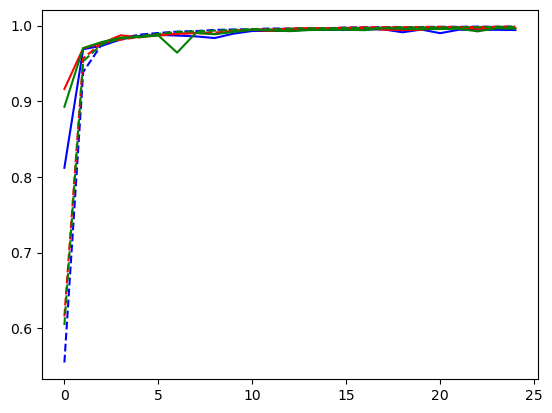

In [131]:
plt.figure(1)
colors = ['b--','b-','r--','r-','g--','g-']
for i in range(tries):
    plt.plot(range(nepochs), cost_train[i], colors[2*i])
    plt.plot(range(nepochs), cost_test[i], colors[2*i+1])

plt.figure(2)
for i in range(tries):
    plt.plot(range(nepochs), acc_train[i], colors[2*i])
    plt.plot(range(nepochs), acc_test[i], colors[2*i+1])

In [126]:
batchsize = 32
nepochs = 25
lr = 0.001

train_cost = {}
train_acc = {}
test_cost = {}
test_acc = {}

for seqlen in range(5,20):
    model = LSTMNet(ninput = 10, nhidden = 50, noutput = 2)
    print("SEQ LENGTH: ", seqlen)
    cost_train, acc_train, cost_test, acc_test = run_experiment(seqlen, nepochs, batchsize, model, lr)
    train_cost[seqlen] = cost_train
    train_acc[seqlen] = acc_train
    test_cost[seqlen] = cost_test
    test_acc[seqlen] = acc_test

SEQ LENGTH:  5
0 0.6928205277701638 0.50308 0.6829575547775902 0.5647
1 0.3223565851832172 0.8515 0.12106809249748818 0.9652
2 0.09286076870198127 0.97266 0.0722436195941636 0.9825
3 0.05793723042846389 0.98348 0.0563958154220622 0.9809
4 0.04060936012345242 0.98848 0.035319974935336854 0.9903
5 0.02952848075694206 0.99182 0.030525645248579997 0.9915
6 0.0235520067377989 0.99306 0.021320102386735974 0.9934
7 0.017796001270714602 0.99502 0.015960842006863617 0.9962
8 0.015059272422264876 0.99564 0.01107673891851628 0.9962
9 0.011476783536191939 0.99668 0.014103341238709322 0.9959
10 0.010553390953633356 0.99704 0.01215066984836079 0.9964
11 0.008569437272281976 0.99748 0.015053452889118106 0.996
12 0.008671143484222989 0.99766 0.023677319831370315 0.9938
13 0.007989255090959551 0.9977 0.012464787906255966 0.9965
14 0.008052113643702055 0.9974 0.008230200296644636 0.9974
15 0.005855187134069648 0.99832 0.011612201854186772 0.9968
16 0.004587233453879056 0.99862 0.01012234616350158 0.9974

In [127]:
plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_test, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_test, "r-")

In [128]:
seqlengths = np.array([seql for seql,acc in train_acc.items()])*2
err_train = 1.0-np.array([acc[-1] for seql,acc in train_acc.items()])
err_test = 1.0-np.array([acc[-1] for seql,acc in test_acc.items()])

([<matplotlib.axis.XTick at 0x145501b50>,
 [Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28')])

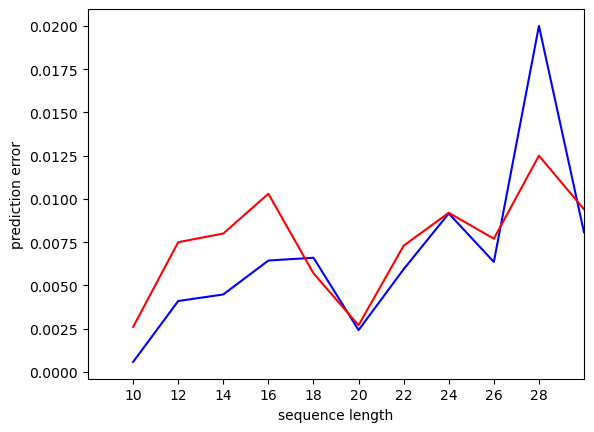

In [129]:
plt.plot(seqlengths, err_train, "b-")
plt.plot(seqlengths, err_test, "r-")
plt.xlabel("sequence length")
plt.ylabel("prediction error")
plt.xlim(8,30)
plt.xticks(np.arange(10,30,2))

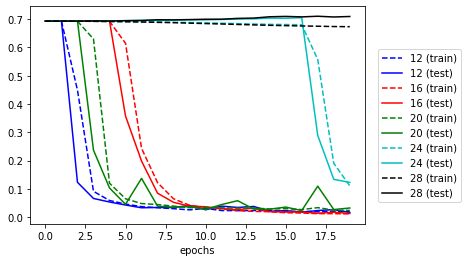

In [138]:
epochs = range(nepochs)
seqs = [seql for seql,acc in train_acc.items()]
colors = ["b","r","g","c","k"]
i = 0
for seql in seqs:
    if seql % 2==0:
        plt.plot(epochs, train_cost[seql], "%s--"%colors[i], label="%i (train)"%(2*seql))
        plt.plot(epochs, test_cost[seql], "%s-"%colors[i], label="%i (test)"%(2*seql))
        i += 1
plt.xlabel("epochs")
plt.legend(loc=(1.04,0.1))

In [146]:
class LSTMNet(torch.nn.Module):
    def __init__(self, ninput, nhidden, noutput):
        super().__init__()
        self.lstm = torch.nn.LSTM(ninput, nhidden, batch_first=True)
        self.linear_h2y = torch.nn.Linear(nhidden, noutput)

    def forward(self, input):
        nsamples, nhidden = input.size(0), self.linear_h2y.weight.size(1) 
        output, _ = self.lstm(input)
        h = torch.nn.functional.relu(output[:,-1])
        return self.linear_h2y(h)

In [148]:
batchsize = 32
nepochs = 20
lr = 0.001

train_cost_lstm = {}
train_acc_lstm = {}
test_cost_lstm = {}
test_acc_lstm = {}

for seqlen in range(13,16):
    model = LSTMNet(ninput = 10, nhidden = 50, noutput = 2)
    print("SEQ LENGTH: ", seqlen)
    cost_train, acc_train, cost_test, acc_test = run_experiment(seqlen, nepochs, batchsize, model, lr)
    train_cost_lstm[seqlen] = cost_train
    train_acc_lstm[seqlen] = acc_train
    test_cost_lstm[seqlen] = cost_test
    test_acc_lstm[seqlen] = acc_test

SEQ LENGTH:  13
0 0.6933816161128243 0.5 0.6933168239486865 0.4923
1 0.6932535893399976 0.5009 0.6933337002516554 0.4933
2 0.6931848421511708 0.50278 0.6933551803945353 0.5003
3 0.6930635597030093 0.5054 0.6909585339954486 0.5274
4 0.6671760938370449 0.57276 0.5681753388989847 0.7389
5 0.4070594058022313 0.82034 0.3295273554210846 0.8795
6 0.17963415266193988 0.9398 0.12546915677004158 0.9589
7 0.12074116922400162 0.96222 0.0864669601180064 0.9716
8 0.09771350659733913 0.97006 0.08859447740054073 0.9695
9 0.07550953346753275 0.9777 0.08925537209505566 0.9699
10 0.07114530927355635 0.97938 0.04847702566391458 0.9862
11 0.06052227106847474 0.98254 0.06021746104440322 0.9837
12 0.05435931195400093 0.98442 0.03619979462919596 0.9899
13 0.0483987725294247 0.98674 0.04221518961311029 0.9869
14 0.04219803411867505 0.9886 0.03540297815376839 0.9913
15 0.041248904709389606 0.98842 0.02768149924131271 0.993
16 0.04056061809970112 0.98832 0.030832467375311274 0.9916
17 0.037163310967816575 0.9897

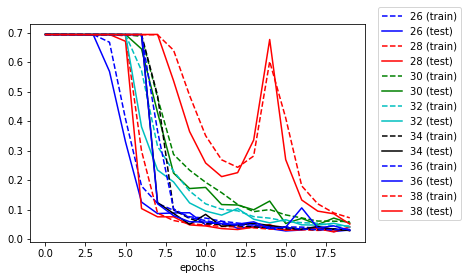

In [154]:
epochs = range(nepochs)
seqs = [seql for seql,acc in train_acc_lstm.items()]
colors = ["b","r","g","c","k","b","r"]
i = 0
for seql in seqs:
    plt.plot(epochs, train_cost_lstm[seql], "%s--"%colors[i], label="%i (train)"%(2*seql))
    plt.plot(epochs, test_cost_lstm[seql], "%s-"%colors[i], label="%i (test)"%(2*seql))
    i += 1
plt.xlabel("epochs")
plt.legend(loc=(1.04,0.1))

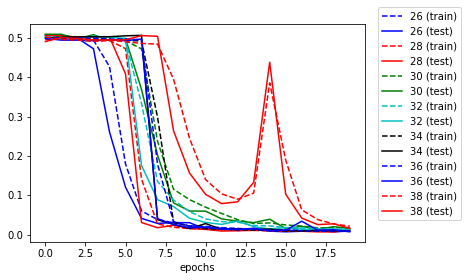

In [157]:
epochs = range(nepochs)
seqs = [seql for seql,acc in train_acc_lstm.items()]
colors = ["b","r","g","c","k","b","r"]
i = 0
for seql in seqs:
    plt.plot(epochs, 1-np.array(train_acc_lstm[seql]), "%s--"%colors[i], label="%i (train)"%(2*seql))
    plt.plot(epochs, 1-np.array(test_acc_lstm[seql]), "%s-"%colors[i], label="%i (test)"%(2*seql))
    i += 1
plt.xlabel("epochs")
plt.legend(loc=(1.04,0.1))

In [151]:
for seqlen in range(16,20):
    model = LSTMNet(ninput = 10, nhidden = 50, noutput = 2)
    print("SEQ LENGTH: ", seqlen)
    cost_train, acc_train, cost_test, acc_test = run_experiment(seqlen, nepochs, batchsize, model, lr)
    train_cost_lstm[seqlen] = cost_train
    train_acc_lstm[seqlen] = acc_train
    test_cost_lstm[seqlen] = cost_test
    test_acc_lstm[seqlen] = acc_test

SEQ LENGTH:  16
0 0.6934044287895744 0.49818 0.6933419574944737 0.4968
1 0.6932593680160288 0.49936 0.693123893996778 0.5026
2 0.6931768919669583 0.5044 0.6931357972157268 0.5029
3 0.6931450829167284 0.50414 0.6936249079795691 0.4955
4 0.6930697953479837 0.50524 0.6941843067114346 0.4986
5 0.6929372087626295 0.50714 0.6934956475949516 0.5007
6 0.5710100758765954 0.66688 0.3803768850172671 0.8243
7 0.31444385461390056 0.86502 0.23404948503826373 0.9113
8 0.2295760696876606 0.91202 0.19370075334280062 0.9289
9 0.16308188288974898 0.94172 0.12257064923572654 0.9587
10 0.11943732332962584 0.96026 0.0950431183230477 0.9692
11 0.10113670109960078 0.96714 0.0812189998253942 0.9741
12 0.09573038614230493 0.96858 0.10380010899251547 0.9658
13 0.0761619010440867 0.9768 0.06732648477023735 0.9799
14 0.07098860471564215 0.97814 0.05496302338543173 0.9858
15 0.06065772207412435 0.98224 0.06566109344327507 0.9824
16 0.05564678170788564 0.98334 0.0482863324483077 0.9863
17 0.05356107186511164 0.98464

In [155]:
batchsize = 32
nepochs = 20
lr = 0.001

train_cost2 = {}
train_acc2 = {}
test_cost2 = {}
test_acc2 = {}

for seqlen in range(13,18):
    model = RecNet(ninput = 10, nhidden = 110, noutput = 2)
    print("SEQ LENGTH: ", seqlen)
    cost_train, acc_train, cost_test, acc_test = run_experiment(seqlen, nepochs, batchsize, model, lr)
    train_cost2[seqlen] = cost_train
    train_acc2[seqlen] = acc_train
    test_cost2[seqlen] = cost_test
    test_acc2[seqlen] = acc_test

SEQ LENGTH:  13
0 0.6942644866704178 0.49698 0.6936638869416599 0.4919
1 0.6933618695096793 0.50428 0.6947827192541128 0.4887
2 0.6928979614874681 0.51396 0.6944632318834908 0.4962
3 0.6920751723355386 0.51856 0.6959022862461809 0.4936
4 0.6904963402510147 0.52874 0.6963080141110162 0.4984
5 0.6881893965119517 0.53866 0.6980858416603015 0.4974
6 0.6855145282876545 0.5502 0.6996365890335351 0.5036
7 0.6055720612187456 0.63694 0.32928141204122535 0.8819
8 0.26326015803746056 0.90188 0.21309863609342147 0.9229
9 0.18600928698566885 0.93616 0.2752866630022899 0.8895
10 0.1673891704174394 0.94314 0.14204859225371014 0.955
11 0.14191723818237095 0.9541 0.12511642306400372 0.9602
12 0.1325330111369138 0.95726 0.1274910994504873 0.9626
13 0.12700028091452192 0.9588 0.11679275486225518 0.9651
14 0.11906781486430404 0.96148 0.11822727416008234 0.9636
15 0.11367846398673337 0.96394 0.10106591777965283 0.9667
16 0.11076208461202343 0.96494 0.0982578140847123 0.9685
17 0.11621161423604494 0.96194 0

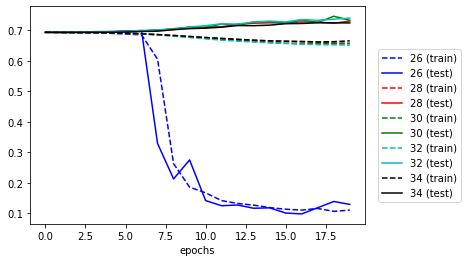

In [158]:
epochs = range(nepochs)
seqs = [seql for seql,acc in train_acc2.items()]
colors = ["b","r","g","c","k","b","r"]
i = 0
for seql in seqs:
    plt.plot(epochs, train_cost2[seql], "%s--"%colors[i], label="%i (train)"%(2*seql))
    plt.plot(epochs, test_cost2[seql], "%s-"%colors[i], label="%i (test)"%(2*seql))
    i += 1
plt.xlabel("epochs")
plt.legend(loc=(1.04,0.1))

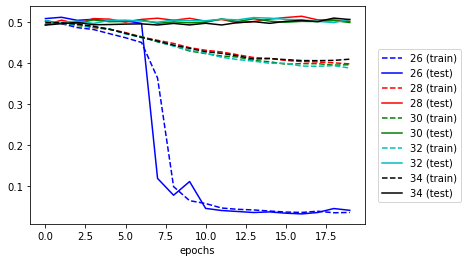

In [159]:
epochs = range(nepochs)
seqs = [seql for seql,acc in train_acc2.items()]
colors = ["b","r","g","c","k","b","r"]
i = 0
for seql in seqs:
    plt.plot(epochs, 1-np.array(train_acc2[seql]), "%s--"%colors[i], label="%i (train)"%(2*seql))
    plt.plot(epochs, 1-np.array(test_acc2[seql]), "%s-"%colors[i], label="%i (test)"%(2*seql))
    i += 1
plt.xlabel("epochs")
plt.legend(loc=(1.04,0.1))